In [1]:
import sklearn
import numpy as np
import pandas as pd
import xgboost as xg
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline  

In [2]:
equal_no_samples_in_each_class = False
datapath = '/home/tracek/Data/gender/gender_descriptors.csv'
seed = 42

params = {'max_depth': 13,
          'n_estimators': 1000,
          'objective': 'binary:logistic',
          'eval_metric': ['auc', 'error'],
          'gamma': 0.1}

test_fraction = 0.1
val_fraction = 0.2

In [3]:
data = pd.read_csv(datapath).drop(['filename'], axis=1) # centroid corresponds to meanfreq
male_df_len = len(data[data['label'] == 0])
female_df_len = len(data[data['label'] == 1])

In [4]:
if equal_no_samples_in_each_class:
    fraction_to_drop = 1 - female_df_len / male_df_len
    data = data.drop(data[data['label'] == 0].sample(frac=fraction_to_drop, random_state=seed).index)

In [5]:
y = data.pop('label')

In [6]:
if test_fraction > 0.0:
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=test_fraction, random_state=seed, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_fraction, random_state=seed, stratify=y_train)
    dtest = xg.DMatrix(X_test, label=y_test)
else:
    X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=val_fraction, random_state=seed, stratify=y)

In [7]:
dtrain = xg.DMatrix(X_train, label=y_train)
dval = xg.DMatrix(X_val, label=y_val)
evallist = [(dval, 'eval'), (dtrain, 'train')]
model = xg.train(params=params, dtrain=dtrain, num_boost_round=100, evals=evallist, early_stopping_rounds=5)

[0]	eval-auc:0.983143	eval-error:0.036805	train-auc:0.990245	train-error:0.016436
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 5 rounds.
[1]	eval-auc:0.985882	eval-error:0.033314	train-auc:0.991956	train-error:0.012264
[2]	eval-auc:0.989226	eval-error:0.028639	train-auc:0.99497	train-error:0.009808
[3]	eval-auc:0.990468	eval-error:0.026982	train-auc:0.99602	train-error:0.008876
[4]	eval-auc:0.991436	eval-error:0.025799	train-auc:0.996771	train-error:0.007071
[5]	eval-auc:0.992081	eval-error:0.02497	train-auc:0.997752	train-error:0.005858
[6]	eval-auc:0.992432	eval-error:0.024083	train-auc:0.998013	train-error:0.004719
[7]	eval-auc:0.993452	eval-error:0.022544	train-auc:0.998798	train-error:0.003817
[8]	eval-auc:0.993851	eval-error:0.02213	train-auc:0.998921	train-error:0.003329
[9]	eval-auc:0.994104	eval-error:0.021657	train-auc:0.999188	train-error:0.002796
[10]	eval-auc:0.994616	eval-error:0.02

In [8]:
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

In [9]:
r = metrics.classification_report(y_true=y_test, y_pred=y_pred)
acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

In [10]:
print(r)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      7882
          1       0.98      0.95      0.96      1507

avg / total       0.99      0.99      0.99      9389



In [11]:
print('Accuracy: ', acc)

Accuracy:  0.988390669933


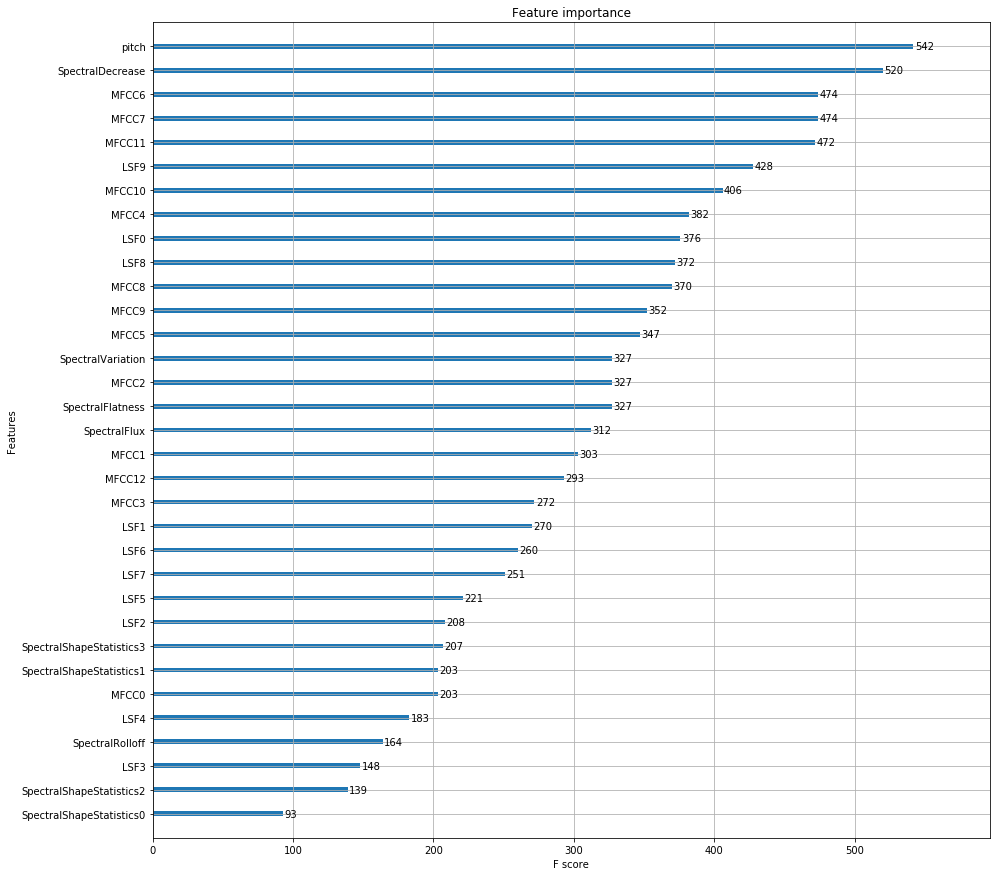

In [12]:
model.feature_names = [name.replace(' ', '') for name in model.feature_names]
fig, ax = plt.subplots(figsize=(15, 15))
xg.plot_importance(model, ax)

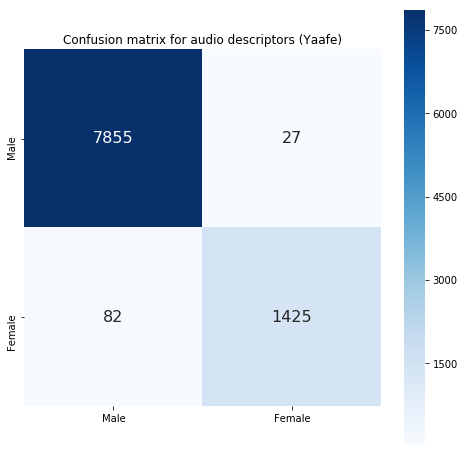

In [31]:
plt.figure(figsize=(8, 8))
plt.title('Confusion matrix for audio descriptors (Yaafe)')
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g', square=True,
            xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])

array(['Male', 'Male', 'Male', ..., 'Male', 'Male', 'Male'],
      dtype='<U6')